## Wind&Wave data analysis

### Load bullet screen and thumb up data

In [39]:
import sys
import jieba
import stylecloud
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyecharts.charts import Bar
from pyecharts import options as opts
from pyecharts.options.global_options import ThemeType
from pyecharts.globals import WarningType
from IPython.display import Image
WarningType.ShowWarning = False 

In [40]:
print(sys.executable)
bullet = pd.read_csv('data/bullet.csv')
bullet.head(10)

D:\Program Files\Python37\python.exe


,date,content,thumbUp
0,0621,昕姐冲！！！,24
1,0621,在看一次！,0
2,0621,为黄圣依，张雨绮，郑希怡打call,10
3,0621,姐姐们 我来了~~！！！,21
4,0621,我去，真的爱了，都是我喜欢的,13
5,0621,揭谛揭谛揭谛快点快点开始考科三考试,0
6,0621,支持杨幂,57
7,0621,啊啊啊坤坤我来了,44
8,0621,顾以森报道哈哈哈哈哈哈哈哈哈,14
9,0621,姐姐冲啊,19


### load wikipedia data that includes player information and game information

In [41]:
wiki = pd.read_csv('data/wikipedia.csv')
player = wiki.loc[:, ['本名']]
# player = pd.DataFrame(wiki['本名'])
player['昵称'] = ['蓝盈莹|盈莹', '黄龄', '丹妮', '孟佳', '梦辰', 
                     '可唯', '宁静|静静子|静姐', '霏霏', '希怡', '袁咏琳',
                     '圣依|依依子', '金晨', '阿朵', '含韵', '白冰',
                     '钟丽缇', '茜', '张萌|萌萌子', '婧汐', '丁当',
                     '许飞', '刘芸|芸芸子', '吴昕|昕昕子|昕姐|昕昕', '伊能静', '松伶',
                     '丽坤', '张雨绮|雨绮|绮绮子', '海陆', '金莎', '王智']
player.loc[0:2, :]

,本名,昵称
0,蓝盈莹,蓝盈莹|盈莹
1,黄龄,黄龄
2,李斯丹妮,丹妮


### get palyers' nickname

In [42]:
nick_name = player.loc[:, '昵称'].to_list()
nick_name

['蓝盈莹|盈莹',
 '黄龄',
 '丹妮',
 '孟佳',
 '梦辰',
 '可唯',
 '宁静|静静子|静姐',
 '霏霏',
 '希怡',
 '袁咏琳',
 '圣依|依依子',
 '金晨',
 '阿朵',
 '含韵',
 '白冰',
 '钟丽缇',
 '茜',
 '张萌|萌萌子',
 '婧汐',
 '丁当',
 '许飞',
 '刘芸|芸芸子',
 '吴昕|昕昕子|昕姐|昕昕',
 '伊能静',
 '松伶',
 '丽坤',
 '张雨绮|雨绮|绮绮子',
 '海陆',
 '金莎',
 '王智']

### get thumb up(votes) information from bullet screen

In [43]:
thumbUpList = []
for name in nick_name:
    thumb_bullet = bullet.loc[bullet['content'].str.contains(name)]
    thumbUp = thumb_bullet.shape[0]
    thumbUpList.append(thumbUp)
player['thumbUp'] = thumbUpList
player.head()

,本名,昵称,thumbUp
0,蓝盈莹,蓝盈莹|盈莹,392
1,黄龄,黄龄,747
2,李斯丹妮,丹妮,341
3,孟佳,孟佳,284
4,沈梦辰,梦辰,826


### Normalized

In [44]:
range = player['thumbUp'].max() - player['thumbUp'].min()
minMax = (player['thumbUp'] - player['thumbUp'].min()) / range
#player['normalization'] = round(minMax * 100, 1)
player['normalization'] = round(minMax, 3)
rank = player.sort_values(by=['normalization'])[['本名', 'thumbUp', 'normalization']]
rank

,本名,thumbUp,normalization
7,王霏霏,221,0.000
9,袁咏琳,238,0.006
18,朱婧汐,251,0.011
3,孟佳,284,0.022
21,刘芸,296,0.026
29,王智,329,0.038
2,李斯丹妮,341,0.042
24,陈松伶,384,0.057
0,蓝盈莹,392,0.060
12,阿朵,416,0.068


### rank

In [45]:
bar = (
    Bar(init_opts=opts.InitOpts(width='800px', height='600px', theme=ThemeType.MACARONS))
    .add_xaxis(rank['本名'].to_list())
    .add_yaxis('rank', rank['thumbUp'].to_list())
    .reversal_axis()
    .set_global_opts(title_opts=opts.TitleOpts(title='选手排名'))
)
bar.render_notebook()

### define cut words function

In [51]:
stop_words = pd.read_csv('data/stopword.csv').loc[:, 'word'].to_list()
stop_words_ex = ['第一期', '一堆', '三个', '真的', '哈哈哈', '哈哈哈哈', '啊啊啊']
stop_words.extend(stop_words_ex)

def get_cut_words(contents: pd.Series):
    key_words = player['昵称'].str.cat(sep="|").replace('|', ':').split(':')
    
    key_words_ex = ['杜华', '辣鸡', '导演组', '节目组', '不公平', '黄圣依', '无杜华版'] 
    for i in key_words:
        jieba.add_word(i) 
    for j in key_words_ex:
        jieba.add_word(j) 
    # cut words
    cut_words = jieba.lcut(contents.str.cat(sep='|'), cut_all=False)

    # filter
    cut_words_filter = [i for i in cut_words if i not in stop_words and len(i) >= 2]
    return cut_words_filter

### draw wordcloud of full view

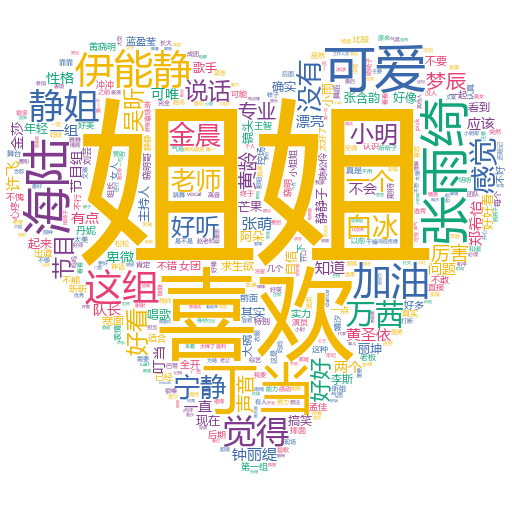

In [52]:
total = get_cut_words(contents=bullet.content)

stylecloud.gen_stylecloud(text=' '.join(total),
                          collocations=False,
                          font_path='msyh.ttc',
                          icon_name='fas fa-heart',
                        #   icon_name='fab fa-github-square',
                          custom_stopwords=stop_words,
                          add_stopwords=True,
                          output_name='data/fullview.png')
Image(filename='data/fullview.png')

### draw wordcloud of zhangyuqi

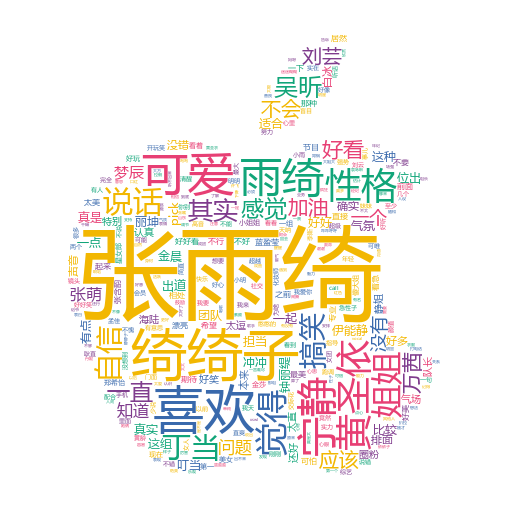

In [48]:
zyq = get_cut_words(contents=bullet.content[bullet.content.str.contains('张雨绮|雨绮|绮绮子')])

stylecloud.gen_stylecloud(text=' '.join(zyq), 
                          collocations=False,
                          font_path='msyh.ttc',
                          icon_name='fab fa-apple',
                          custom_stopwords=stop_words,
                          add_stopwords=True,
                          output_name='data/zyq.png')
Image(filename='data/zyq.png')

### draw wordcloud of ningjing

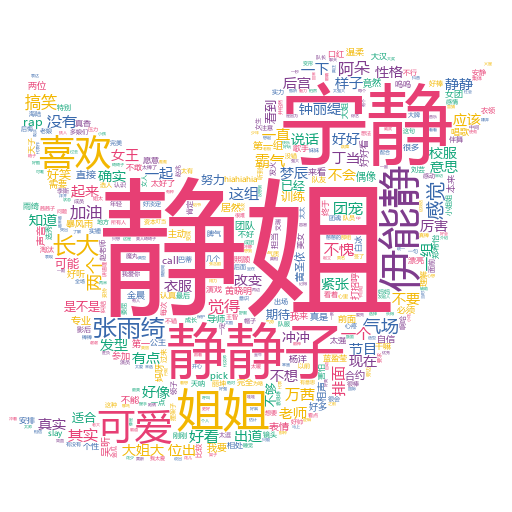

In [49]:
ningjing = get_cut_words(contents=bullet.content[bullet.content.str.contains('宁静|静静子|静姐')])

stylecloud.gen_stylecloud(text=' '.join(ningjing), 
                          collocations=False,
                          font_path='msyh.ttc',
                          icon_name='fab fa-twitter',
                          custom_stopwords=stop_words,
                          add_stopwords=True,
                          output_name='data/ningjing.png')
Image(filename='data/ningjing.png')